In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def read_spikes_from_disk(path):
    data = np.load(path)

    # compatability with old datasets
    val_filenames = []
    if 'validation_filenames' in data:
        val_filenames = data['validation_filenames']

    return data['train_set'], data['train_labels'], data['train_gunshot_data'], data['validation_set'], data['validation_labels'], data['validation_gunshot_data'], val_filenames, data['test_set'], data['test_labels']

In [3]:
# for now let's take the output from snn/make_dataset.py
# it generates a DWT spectrogram matrix that is normalized to 0-1

training_data, training_labels, _, validation_data, validation_labels, _, _, test_data, test_labels = read_spikes_from_disk('../snn/data/1200-dwt.npz')

In [4]:
training_data = torch.tensor(training_data)
training_data = training_data.permute(2, 0, 1) 
print(training_data.shape)

# note: delta expects shape (timestep, batch, neuron), also used for input to snn
dm_train_data = spikegen.delta(training_data, threshold=0.005)
print(dm_train_data.shape)

dm_train_data = dm_train_data.to(device)

torch.Size([461, 960, 7])
torch.Size([461, 960, 7])


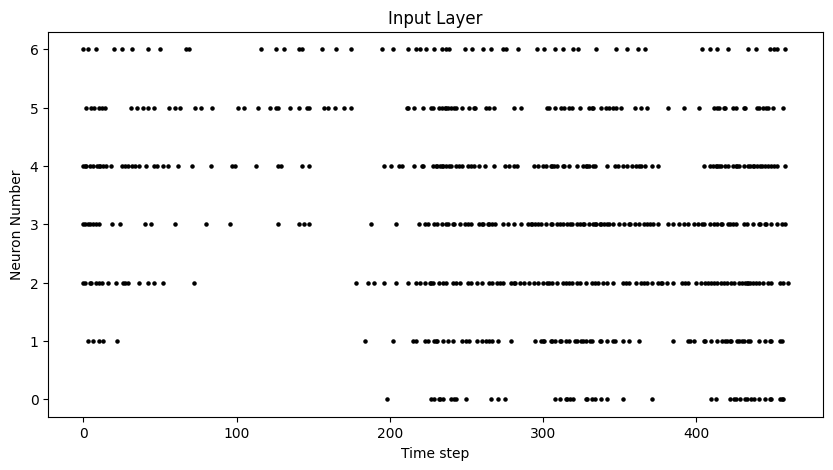

In [5]:
# visualize one sample raster
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(dm_train_data[:, 99, :], ax, s=5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [14]:
# Now the network
# Let's try a FFN
# 7x250x250x2
# see https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_5.html
beta = 0.9 # slow decay
num_timesteps = dm_train_data.shape[0] + 100 

class SNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 250)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(250, 250)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(250, 2)
        self.lif3 = snn.Leaky(beta=beta)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spikes = []
        
        for step in range(num_timesteps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            spikes.append(spk3)

        return spikes

In [15]:
net = SNN().to(device)

In [16]:
# train
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))

In [17]:
y = net.forward(dm_train_data[0])

In [21]:
for k in y:
    print(k.sum())

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(0., device='cuda:0', grad_fn=<SumBackward0>)
tensor(4., device='cuda:0', grad_fn=<SumBackward0>)
tensor(6., device='cuda:0', grad_fn=<SumBackward0>)
tensor(10., 